In [5]:
!pip install tf_keras
!pip install transformers huggingface_hub

print("\n--- Libraries installed. Please RESTART YOUR RUNTIME ---")


--- Libraries installed. Please RESTART YOUR RUNTIME ---


In [1]:
# --- CRITICAL FIX: Set Environment Variable ---
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
# ---------------------------------------------

import re
import pandas as pd
import tensorflow as tf
import tf_keras # Import the new Keras package
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
from huggingface_hub import hf_hub_download
import warnings
from google.colab import drive, files

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

print(f"Using TensorFlow version: {tf.__version__}")
import transformers
print(f"Using Transformers version: {transformers.__version__}")

# --- 1. Mount Drive ---
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# --- 2. Upload CSV ---
print("\nPlease upload your 'total_df.csv' file:")
uploaded_csv = files.upload()
total_df_path = list(uploaded_csv.keys())[0]

# --- 3. Set Paths ---
dataset_path = "/content/drive/MyDrive/DAICWOZ_MAIN"
model_name = "distilbert-base-uncased"
print(f"\nCSV path set to: {total_df_path}")
print(f"Dataset path set to: {dataset_path}")

# --- 4. VITAL CHECK ---
print("\nChecking for data at Drive path:")
!ls -l "{dataset_path}" | head -n 10

Using TensorFlow version: 2.19.0
Using Transformers version: 4.57.1

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Please upload your 'total_df.csv' file:


Saving total_df.csv to total_df (5).csv

CSV path set to: total_df (5).csv
Dataset path set to: /content/drive/MyDrive/DAICWOZ_MAIN

Checking for data at Drive path:
total 760
drwx------ 2 root root 4096 Oct 22 13:47 300_P
drwx------ 2 root root 4096 Oct 22 13:47 301_P
drwx------ 2 root root 4096 Oct 22 13:47 302_P
drwx------ 2 root root 4096 Oct 22 13:47 303_P
drwx------ 2 root root 4096 Oct 22 13:47 304_P
drwx------ 2 root root 4096 Oct 22 13:47 305_P
drwx------ 2 root root 4096 Oct 22 13:47 306_P
drwx------ 2 root root 4096 Oct 22 13:47 307_P
drwx------ 2 root root 4096 Oct 22 13:47 308_P


In [2]:
def parse_daicwoz_transcript(filepath):
    """
    Parses the DAIC-WOZ transcript file.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    header = ['start_time', 'stop_time', 'speaker', 'value']
    rows = []
    for line in lines[1:]:  # Skip header row in file
        try:
            line_split = re.split(r'\t| {2,}', line.strip())
            if len(line_split) == 4:
                rows.append(line_split)
            elif len(line_split) > 4:
                rows.append(line_split[:3] + [' '.join(line_split[3:])])
            else:
                line_split_alt = re.split(r'\s+', line.strip())
                if len(line_split_alt) >= 4:
                    rows.append(line_split_alt[:4])
        except Exception as e:
            print(f"Skipping line in {filepath} due to error: {e}. Line: {line}")

    df = pd.DataFrame(rows, columns=header)
    return df

def load_all_transcripts(parent_dir):
    """
    Iterates through all session folders, parses transcripts,
    and extracts only 'Participant' text.
    """
    print(f"Loading all transcripts from: {parent_dir}")
    texts, participant_ids = [], []

    if not os.path.exists(parent_dir):
        print(f"ERROR: The directory '{parent_dir}' does not exist.")
        return pd.DataFrame()

    session_list = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f)) and f.endswith('_P')]

    for session_folder in session_list:
        session_path = os.path.join(parent_dir, session_folder)
        participant_id = session_folder.split('_')[0]

        try:
            transcript_file_name = [f for f in os.listdir(session_path) if 'TRANSCRIPT' in f and f.endswith('.csv')][0]
            transcript_filepath = os.path.join(session_path, transcript_file_name)
        except IndexError:
            print(f"Warning: No '...TRANSCRIPT.csv' file found in {session_folder}. Skipping.")
            continue

        try:
            df_t = parse_daicwoz_transcript(transcript_filepath)
            utterances = df_t[df_t['speaker'].str.strip().str.lower() == 'participant']['value'].dropna().astype(str).tolist()

            if not utterances:
                print(f"Warning: No participant utterances found for {participant_id}. Skipping.")
                continue

            full_text = " ".join(utterances)
            texts.append(full_text)
            participant_ids.append(participant_id)

        except Exception as e:
            print(f"Error parsing transcript for {participant_id}: {e}")

    print(f"Successfully loaded and processed {len(texts)} transcripts.")
    return pd.DataFrame({
        "participant_id": participant_ids,
        "text": texts
    })

# --- Execute Data Loading ---
text_df = load_all_transcripts(dataset_path)

if not text_df.empty:
    print(f"Loading labels from {total_df_path}...")

    labels_df = pd.read_csv(total_df_path)

    print(f"Merging {len(text_df)} transcripts with {len(labels_df)} labels.")
    text_df['participant_id'] = text_df['participant_id'].astype(str)
    labels_df['Participant_ID'] = labels_df['Participant_ID'].astype(str)

    df = pd.merge(text_df, labels_df, left_on='participant_id', right_on='Participant_ID')

    df = df[['participant_id', 'text', 'PHQ8_Binary']]
    df = df.rename(columns={'PHQ8_Binary': 'label'})
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    print("\nData loading complete. DataFrame head:")
    print(df.head())
    print(f"\nTotal records loaded: {len(df)}")
    print("\nData distribution:")
    print(df['label'].value_counts())
else:
    print("Data loading failed. Please check your path in Step 3.")

Loading all transcripts from: /content/drive/MyDrive/DAICWOZ_MAIN
Successfully loaded and processed 189 transcripts.
Loading labels from total_df (5).csv...
Merging 189 transcripts with 189 labels.

Data loading complete. DataFrame head:
  participant_id                                               text  label
0            407  <sync> yes <clears throat> i'm actually feel <...      0
1            400  <synch> yeah i'm fine um pacific grove califor...      0
2            393  <sync> yes i'm good i'm originally from los an...      0
3            408  <sync> yes i am i'm doing great i am originall...      0
4            391  <sync> yes kind of down i don't have a boyfrie...      0

Total records loaded: 189

Data distribution:
label
0    133
1     56
Name: count, dtype: int64


In [3]:
print("\nPreprocessing data...")
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_enc = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), train_labels)).shuffle(1000).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices((dict(test_enc), test_labels)).batch(8)
print("Data preprocessing complete.")

print("\nBuilding and training model...")

# --- THIS IS THE FINAL, GUARANTEED FIX ---
# 1. Load the model's configuration
print("Loading model config...")
config = AutoConfig.from_pretrained(model_name, num_labels=2)

# 2. Create a "blank" model skeleton from the config
print("Creating model from config...")
model = TFAutoModelForSequenceClassification.from_config(config)

# 3. Manually download *only* the TensorFlow weights file
print("Downloading TensorFlow weights...")
weights_path = hf_hub_download(repo_id=model_name, filename="tf_model.h5")

# 4. Build the model by calling it with dummy data
print("Building model variables...")
dummy_input = {
    'input_ids': tf.zeros((8, 256), dtype=tf.int32), # Batch size 8, sequence 256
    'attention_mask': tf.zeros((8, 256), dtype=tf.int32)
}
_ = model(dummy_input) # Call the model once to build it
print("Model variables built.")

# 5. (NEW FIX) Load weights BY NAME and SKIP MISMATCH
print(f"Loading weights from {weights_path}...")
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Model loaded successfully.")
# ----------------------------------------

# --- We now use 'tf_keras' as required ---
optimizer = tf_keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric = tf_keras.metrics.SparseCategoricalAccuracy(name="accuracy")
# ---------------------------------------

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[acc_metric])

epochs = 5
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

print("Model training complete.")


Preprocessing data...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Data preprocessing complete.

Building and training model...
Loading model config...
Creating model from config...
Building model variables...
Model variables built.
Loading weights from /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tf_model.h5...
Model loaded successfully.
Epoch 1/5
19/19 [==============================] - 330s 16s/step - loss: 0.6257 - accuracy: 0.6821 - val_loss: 0.6043 - val_accuracy: 0.7105
Epoch 2/5
19/19 [==============================] - 276s 15s/step - loss: 0.6081 - accuracy: 0.7020 - val_loss: 0.5990 - val_accuracy: 0.7105
Epoch 3/5
19/19 [==============================] - 278s 15s/step - loss: 0.5769 - accuracy: 0.7020 - val_loss: 0.6064 - val_accuracy: 0.7105
Epoch 4/5
19/19 [==============================] - 275s 15s/step - loss: 0.5023 - accuracy: 0.7417 - val_loss: 0.6362 - val_accuracy: 0.6053
Epoch 5/5
19/19 [==============================] - 277s 15s/step - loss: 0.3231 - accuracy: 0.8


--- Model Performance ---


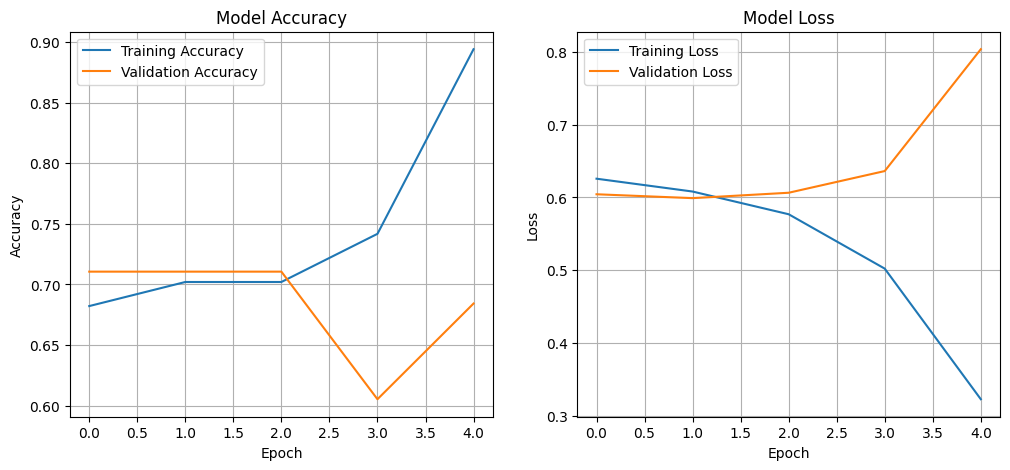


--- Test Set Evaluation ---
5/5 [==============================] - 24s 4s/step
                    precision    recall  f1-score   support

NO (Not Depressed)       0.70      0.96      0.81        27
   YES (Depressed)       0.00      0.00      0.00        11

          accuracy                           0.68        38
         macro avg       0.35      0.48      0.41        38
      weighted avg       0.50      0.68      0.58        38

--- Confusion Matrix ---
[[26  1]
 [11  0]]


In [4]:
print("\n--- Model Performance ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Test Set Evaluation ---")
predictions = model.predict(test_ds)
y_pred = np.argmax(tf.nn.softmax(predictions.logits, axis=-1), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

target_names = ['NO (Not Depressed)', 'YES (Depressed)']
print(classification_report(y_true, y_pred, target_names=target_names))
print("--- Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))